In [8]:
import pandas as pd

# Đọc file gốc (header giữ nguyên)
df = pd.read_csv("test_predict.csv")

# Xóa 2 dòng ngay sau header
df_clean = df.drop(index=[0, 1]).reset_index(drop=True)

# Lưu file sạch
df_clean.to_csv("test_predict_clean.csv", index=False)

print("Đã lưu file: test_predict_clean.csv")


C:\Users\pc\AppData\Local\Temp\ipykernel_4604\3977575583.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,25

Đã lưu file: test_predict_clean.csv


Load data + tạo nhóm thu nhập

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load file dự đoán
df = pd.read_csv("test_predict_clean.csv")

# → kiểm tra file có 3 cột: TARGET, prediction, proba
df = df.rename(columns={
    "Gradient Boosting": "prediction",
    "Gradient Boosting (1.0)": "proba"
})

# Convert kiểu dữ liệu
df["prediction"] = df["prediction"].astype(float).astype(int)
df["proba"] = df["proba"].astype(float)

# Tạo income group (low vs high)
median_income = df["AMT_INCOME_TOTAL"].median()
df["INCOME_GROUP"] = np.where(df["AMT_INCOME_TOTAL"] < median_income, "low", "high")

df.head()


,Selected,TARGET,prediction,Gradient Boosting (0.0),proba,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_XNA_SUM,APP_INCOME_CREDIT_RATIO,APP_INCOME_ANNUITY_RATIO,APP_PAYMENT_RATE,BUREAU_INCOME_CREDIT_RATIO,BUREAU_INCOME_DEBT_RATIO,PREV_INCOME_CREDIT_RATIO,INSTALL_INCOME_PAYMENT_RATIO,INCOME_GROUP
0,No,1.0,1,0.183019,0.816981,348740,1,225000.0,497520.0,36184.5,...,0.0,0.0,0.452243,6.21813,0.072730,11.0808,3.59534,0.610560,0.494915,high
1,No,1.0,0,0.820244,0.179756,383144,0,175500.0,500544.0,15358.5,...,0.0,0.0,0.350619,11.42690,0.030684,11.0808,3.59534,22.555400,29.352200,high
2,No,0.0,0,0.680015,0.319985,224892,2,135000.0,450000.0,13644.0,...,0.0,0.0,0.300000,9.89446,0.030320,11.0808,3.59534,3.999730,6.629180,low
3,No,0.0,1,0.412206,0.587794,435899,0,90000.0,450000.0,32877.0,...,0.0,0.0,0.200000,2.73748,0.073060,23.9904,5.87250,0.804050,0.660824,low
4,No,0.0,0,0.846547,0.153453,390220,0,180000.0,1350000.0,39474.0,...,0.0,0.0,0.133333,4.55996,0.029240,5.5875,0.00000,0.624125,0.659017,high


Fairness Feature

In [12]:
# ============================
# 1. Hàm tính TPR - FPR (đã fix lỗi)
# ============================
def get_tpr_fpr(y_true, y_pred):
    # Ép confusion matrix luôn có đủ 2 lớp (0 và 1)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    tn, fp, fn, tp = cm.ravel()

    tpr = tp/(tp+fn) if (tp+fn) > 0 else 0
    fpr = fp/(fp+tn) if (fp+tn) > 0 else 0
    return tpr, fpr


# ============================
# 2. Fairness One-Hot (0 vs 1)
# ============================
def fairness_onehot(df, col):
    mask1 = df[col] == 1
    mask0 = df[col] == 0

    # TPR + FPR
    tpr1, fpr1 = get_tpr_fpr(df.loc[mask1, "TARGET"], df.loc[mask1, "prediction"])
    tpr0, fpr0 = get_tpr_fpr(df.loc[mask0, "TARGET"], df.loc[mask0, "prediction"])

    # Calibration (threshold = 0.6)
    def calib(mask):
        s = df.loc[mask & (df["proba"] >= 0.6), "TARGET"]
        return s.mean() if len(s) > 0 else np.nan

    cal1 = calib(mask1)
    cal0 = calib(mask0)

    return {
        "Feature": col,
        "TPR_Diff": tpr1 - tpr0,
        "FPR_Diff": fpr1 - fpr0,
        "Calib_Diff": (cal1 - cal0 if not np.isnan(cal1) and not np.isnan(cal0) else np.nan)
    }


# ============================
# 3. Fairness Income Group
# ============================
def fairness_income(df):
    mask_low  = df["INCOME_GROUP"] == "low"
    mask_high = df["INCOME_GROUP"] == "high"

    tpr_low,  fpr_low  = get_tpr_fpr(df.loc[mask_low,  "TARGET"], df.loc[mask_low,  "prediction"])
    tpr_high, fpr_high = get_tpr_fpr(df.loc[mask_high, "TARGET"], df.loc[mask_high, "prediction"])

    def calib(mask):
        s = df.loc[mask & (df["proba"] >= 0.6), "TARGET"]
        return s.mean() if len(s) > 0 else np.nan

    cal_low  = calib(mask_low)
    cal_high = calib(mask_high)

    return {
        "Feature": "INCOME_GROUP_low_vs_high",
        "TPR_Diff": tpr_low - tpr_high,
        "FPR_Diff": fpr_low - fpr_high,
        "Calib_Diff": (cal_low - cal_high if not np.isnan(cal_low) and not np.isnan(cal_high) else np.nan)
    }


### FAIRNESS cho FAMILY STATUS

In [13]:
# Lọc các cột one-hot thuộc nhóm Family Status
family_cols = [c for c in df.columns if c.startswith("NAME_FAMILY_STATUS_")]

results_family = []

for col in family_cols:
    results_family.append(fairness_onehot(df, col))

fairness_family_df = pd.DataFrame(results_family)

fairness_family_df

,Feature,TPR_Diff,FPR_Diff,Calib_Diff
0,NAME_FAMILY_STATUS_Civil marriage,0.105787,0.059425,0.033610
1,NAME_FAMILY_STATUS_Married,-0.033589,-0.024778,-0.015071
2,NAME_FAMILY_STATUS_Separated,-0.051669,-0.022000,0.039328
3,NAME_FAMILY_STATUS_Single / not married,0.042854,0.066051,-0.018155
4,NAME_FAMILY_STATUS_Unknown,-0.702554,-0.294749,NaN
5,NAME_FAMILY_STATUS_Widow,-0.142071,-0.119091,0.009614


### FAIRNESS cho INCOME

In [14]:
result_income = fairness_income(df)
fairness_income_df = pd.DataFrame([result_income])

fairness_income_df


,Feature,TPR_Diff,FPR_Diff,Calib_Diff
0,INCOME_GROUP_low_vs_high,0.026828,0.043138,-0.013659


### FAIRNESS cho GENDER

In [15]:
gender_cols = [c for c in df.columns if c.startswith("CODE_GENDER_")]

results_gender = []

for col in gender_cols:
    results_gender.append(fairness_onehot(df, col))

pd.DataFrame(results_gender)


,Feature,TPR_Diff,FPR_Diff,Calib_Diff
0,CODE_GENDER_F,-0.103718,-0.148438,0.002613
1,CODE_GENDER_M,0.103718,0.148438,-0.002613
2,CODE_GENDER_nan,-0.702554,-0.294749,NaN


### FAIRNESS cho EDU

In [16]:
edu_cols = [c for c in df.columns if c.startswith("NAME_EDUCATION_TYPE_")]

results_edu = []

for col in edu_cols:
    results_edu.append(fairness_onehot(df, col))

pd.DataFrame(results_edu)


,Feature,TPR_Diff,FPR_Diff,Calib_Diff
0,NAME_EDUCATION_TYPE_Academic degree,-0.702758,0.705456,-0.766000
1,NAME_EDUCATION_TYPE_Higher education,-0.129104,-0.122383,-0.068698
2,NAME_EDUCATION_TYPE_Incomplete higher,0.019848,0.085320,-0.106580
3,NAME_EDUCATION_TYPE_Lower secondary,-0.059505,0.075828,0.079068
4,NAME_EDUCATION_TYPE_Secondary / secondary special,0.106537,0.090859,0.072311


### FAIRNESS cho AGE GROUP

In [17]:
df["AGE"] = (-df["DAYS_BIRTH"] / 365).astype(int)

df["AGE_GROUP"] = df["AGE"].apply(lambda x:
    "18–30" if x < 30 else
    "30–45" if x < 45 else
    "45–60" if x < 60 else
    "60+")

age_cols = ["AGE_GROUP"]

results_age = []

for g in df["AGE_GROUP"].unique():
    mask = df["AGE_GROUP"] == g
    tpr, fpr = get_tpr_fpr(df.loc[mask, "TARGET"], df.loc[mask, "prediction"])

    # Calibration
    s = df.loc[mask & (df["proba"] >= 0.6), "TARGET"]
    cal = s.mean() if len(s) > 0 else np.nan

    results_age.append({
        "Feature": g,
        "TPR": tpr,
        "FPR": fpr,
        "Calibration": cal
    })

pd.DataFrame(results_age)


,Feature,TPR,FPR,Calibration
0,18–30,0.819832,0.497899,0.759630
1,60+,0.483871,0.153652,0.759259
2,30–45,0.715375,0.325931,0.774026
3,45–60,0.647577,0.223260,0.757216


### FAIRNESS VISUALIZE

In [20]:
# Chuẩn hóa tên DataFrame FAIRNESS
fairness_age_df     = pd.DataFrame(results_age)
fairness_edu_df     = pd.DataFrame(results_edu)
fairness_gender_df  = pd.DataFrame(results_gender)
fairness_income_df  = fairness_income_df          # đã sẵn có
fairness_family_df  = fairness_family_df          # đã sẵn có

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

fairness_all = pd.concat([
    fairness_age_df.assign(Group="AGE"),
    fairness_edu_df.assign(Group="EDUCATION"),
    fairness_gender_df.assign(Group="GENDER"),
    fairness_income_df.assign(Group="INCOME"),
    fairness_family_df.assign(Group="FAMILY")
], ignore_index=True)

display(fairness_all)


,Feature,TPR,FPR,Calibration,Group,TPR_Diff,FPR_Diff,Calib_Diff
0,18–30,0.819832,0.497899,0.759630,AGE,NaN,NaN,NaN
1,60+,0.483871,0.153652,0.759259,AGE,NaN,NaN,NaN
2,30–45,0.715375,0.325931,0.774026,AGE,NaN,NaN,NaN
3,45–60,0.647577,0.223260,0.757216,AGE,NaN,NaN,NaN
4,NAME_EDUCATION_TYPE_Academic degree,NaN,NaN,NaN,EDUCATION,-0.702758,0.705456,-0.766000
5,NAME_EDUCATION_TYPE_Higher education,NaN,NaN,NaN,EDUCATION,-0.129104,-0.122383,-0.068698
6,NAME_EDUCATION_TYPE_Incomplete higher,NaN,NaN,NaN,EDUCATION,0.019848,0.085320,-0.106580
7,NAME_EDUCATION_TYPE_Lower secondary,NaN,NaN,NaN,EDUCATION,-0.059505,0.075828,0.079068
8,NAME_EDUCATION_TYPE_Secondary / secondary special,NaN,NaN,NaN,EDUCATION,0.106537,0.090859,0.072311
9,CODE_GENDER_F,NaN,NaN,NaN,GENDER,-0.103718,-0.148438,0.002613


### VISUALIZE TPR

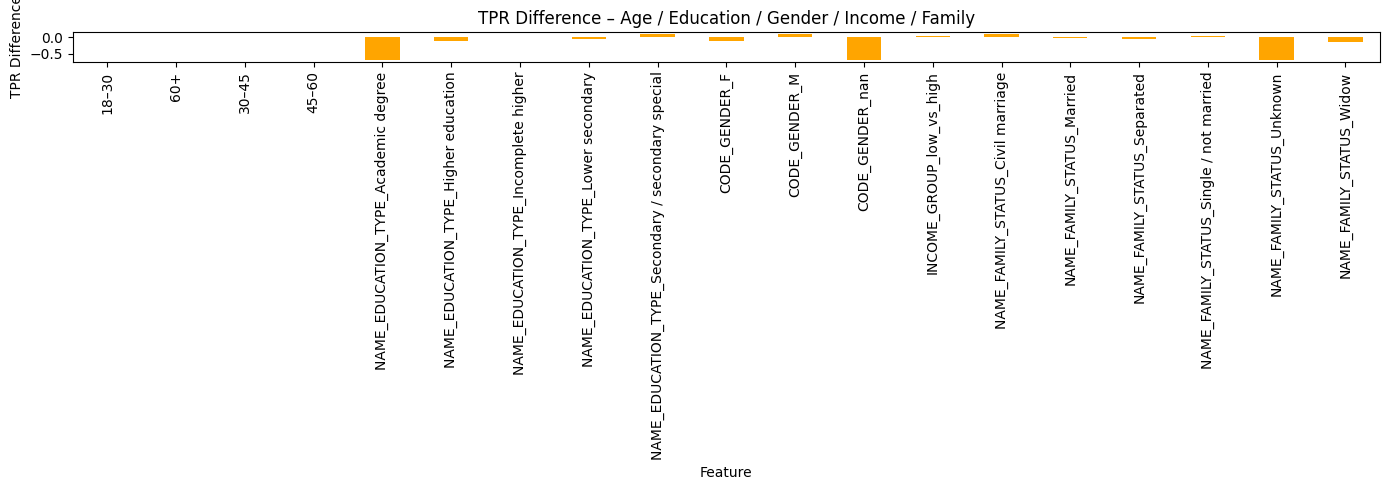

In [22]:
plt.figure(figsize=(14,5))
fairness_all.set_index("Feature")["TPR_Diff"].plot(kind="bar", color="orange")
plt.title("TPR Difference – Age / Education / Gender / Income / Family")
plt.ylabel("TPR Difference")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### VISUALIZE FPR

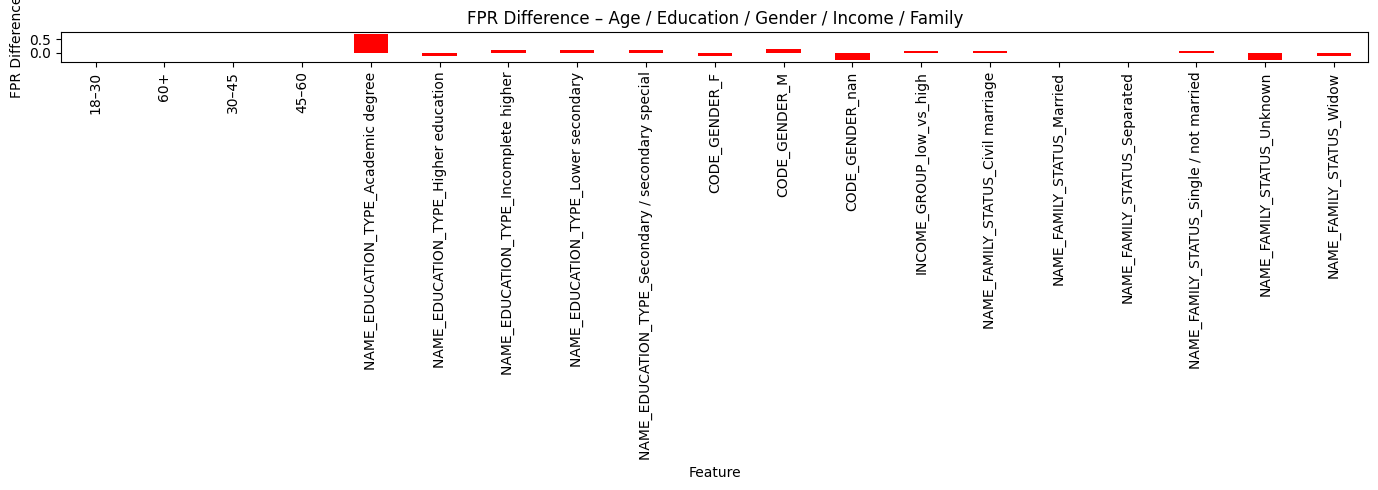

In [23]:
plt.figure(figsize=(14,5))
fairness_all.set_index("Feature")["FPR_Diff"].plot(kind="bar", color="red")
plt.title("FPR Difference – Age / Education / Gender / Income / Family")
plt.ylabel("FPR Difference")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### VISUALIZE Calibration

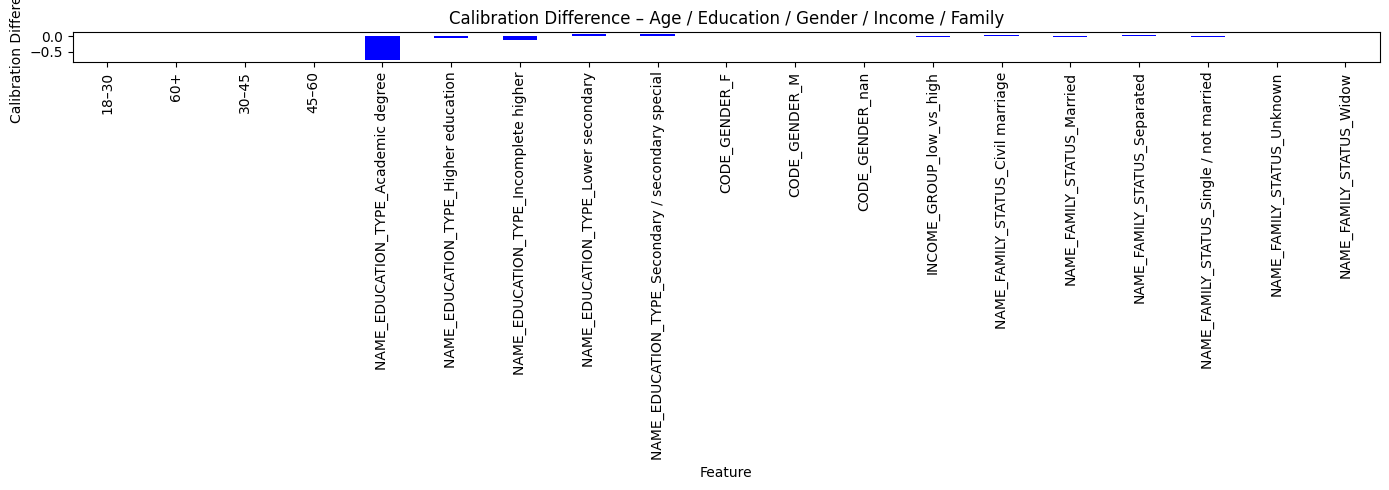

In [24]:
plt.figure(figsize=(14,5))
fairness_all.set_index("Feature")["Calib_Diff"].plot(kind="bar", color="blue")
plt.title("Calibration Difference – Age / Education / Gender / Income / Family")
plt.ylabel("Calibration Difference")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
